In [1]:
#hand digit recognition 
#kekw 

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [1]:
os.chdir(r'C:\Users\cagatayy\deepLearningApplication\datasets\handSignDataset')

NameError: name 'os' is not defined

In [4]:
#burada daha önce veriseti var mı diye kontrol ediliyor.
#yoksa yeni bir dosya açılıyor
if os.path.isdir('train/0/') is False:
    os.mkdir('train')
    os.mkdir('valid')
    os.mkdir('test')

    #train valid test'te 0dan 9a kadar dosya açıldı
    #bütün fotoğraflar traine atıldı.
    for i in range(0, 10):
        shutil.move(f'{i}', 'train')
        os.mkdir(f'valid/{i}')
        os.mkdir(f'test/{i}')
        
        #traindan valide random 37 fotoğraf atıldı
        valid_samples = random.sample(os.listdir(f'train/{i}'), 37)
        for j in valid_samples:
            shutil.move(f'train/{i}/{j}', f'valid/{i}')
        
        #trainden teste random 8er fotoğraf atıldı.
        test_samples = random.sample(os.listdir(f'train/{i}'), 8)
        for k in test_samples:
            shutil.move(f'train/{i}/{k}', f'test/{i}')
os.chdir('../..')
        

In [5]:
#fotoğrafların kullanılması için pathler oluşturuldu.,

train_path = r'C:\Users\cagatayy\deepLearningApplication\datasets\handSignDataset\train'
valid_path = r'C:\Users\cagatayy\deepLearningApplication\datasets\handSignDataset\valid'
test_path  = r'C:\Users\cagatayy\deepLearningApplication\datasets\handSignDataset\test'
        

In [6]:
#training, validation, and test data are stored in directoryIterator
#to create the training, validation, and test data we use ImageDataGenerator.flow_from_directory()
#preprocessing = keras.mobilenet
#target size helps us to resize
#to further explanations, in the next cell all the properties copied.

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), batch_size=5)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), batch_size=5)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), batch_size=5, shuffle=False)

Found 1612 images belonging to 10 classes.
Found 370 images belonging to 10 classes.
Found 80 images belonging to 10 classes.


In [7]:
"""
    tf.keras.preprocessing.image_dataset_from_directory(
        directory,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
        batch_size=32,
    image_size=(256, 256),
        shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
    **kwargs
)
"""

#colabda her attribute guzelce aciklanıyor, bu islem jupyter notebookta yapılıyor biraz acı çekiyorum
#3 gün sonra gelen edit: olum shift tab yapınca oluyormuş :D

'\n    tf.keras.preprocessing.image_dataset_from_directory(\n        directory,\n    labels="inferred",\n    label_mode="int",\n    class_names=None,\n    color_mode="rgb",\n        batch_size=32,\n    image_size=(256, 256),\n        shuffle=True,\n    seed=None,\n    validation_split=None,\n    subset=None,\n    interpolation="bilinear",\n    follow_links=False,\n    crop_to_aspect_ratio=False,\n    **kwargs\n)\n'

In [8]:
#mobile diye değişken atadım, mobile net ağını indirdim. mobilenet vgg'ye göre çok daha hafif.

mobile = tf.keras.applications.mobilenet.MobileNet()
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

In [9]:
#burada yapılan işlem son 5 layerı kaldırmak. global average'a kadar olan layerlar çıkarıldı
#buradaki işlemler sequence ile yapılmıyor, syntax'ı biraz farklı. 

x = mobile.layers[-6].output

In [10]:
#son 6 layer attığımız için doğal olarak bi output layerımız yok
#bunu da kendimiz oluşturuyoruz. 10 tane rakam olduğu için (mobilenet
#in 1000'di bu arada) 10 classlı bir output layer'ı oluşturduk
#aktivasyon fonksiyonu olarak da artık alışıldığı üzere softmax kullandık
#loss'u da categorik cross entropy seçerek güzel bir duo oluştu
#sonraki (x) biraz normalden farklı. mobilenet modeli aslında fonksiyonel
#bir model. yani keras'ın fonksiyonel API'ı, sequential API değil. 
#sequential olsaydı tek tek döngüyle bütün layerları boş bi seq modela
#eklememiz gerekirdi. onun yerine ise, son 5 layerı at, sonra bir output 
#variable'ı oluştur. bu output variable'ı x variable'ın içinden geçir 
#fonksiyonel modele output layer'ını eklemiş ol.


output = Dense(units=10, activation='softmax')(x)

In [11]:
from tensorflow.keras.models import Model

In [12]:
#Model ayrıca kerastaki bir fonksiyon. input olarak orijinal input aldı
#sondan 6. layera kadar ekledi ve son olarak outputu bizim az önce 
#oluşturduğumuz outputu ekledik. voalla. fonksiyonel modelimiz compile  
#ve fit edilmeye hazır.

model = Model(inputs=mobile.input, outputs=output)

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0     

In [14]:
#bu model normalde bütün layerları TRAINABLE şekilde. biz bunu engelleyeceğiz.
#sondan 23 layer'ı eğitilebilir hale getirmeye çalışacağız. yani baştan son 23
#layera kadar bütün layerlar eğitilebilir hale getirildi. kekw

for layer in model.layers[:-23]:
    layer.trainable = False

In [17]:
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
model.fit(
    x=train_batches,
    validation_data=valid_batches,
    epochs=30,
    verbose=2
)

Epoch 1/30
323/323 - 48s - loss: 1.7502 - accuracy: 0.4175 - val_loss: 0.9579 - val_accuracy: 0.7514
Epoch 2/30
323/323 - 46s - loss: 0.8621 - accuracy: 0.8102 - val_loss: 0.5209 - val_accuracy: 0.8973
Epoch 3/30
323/323 - 66s - loss: 0.6126 - accuracy: 0.8679 - val_loss: 0.3462 - val_accuracy: 0.9324
Epoch 4/30
323/323 - 49s - loss: 0.4531 - accuracy: 0.9107 - val_loss: 0.2603 - val_accuracy: 0.9486
Epoch 5/30
323/323 - 55s - loss: 0.3600 - accuracy: 0.9380 - val_loss: 0.2030 - val_accuracy: 0.9568
Epoch 6/30
323/323 - 44s - loss: 0.2930 - accuracy: 0.9442 - val_loss: 0.1725 - val_accuracy: 0.9622
Epoch 7/30
323/323 - 47s - loss: 0.2554 - accuracy: 0.9584 - val_loss: 0.1411 - val_accuracy: 0.9703
Epoch 8/30
323/323 - 52s - loss: 0.2201 - accuracy: 0.9634 - val_loss: 0.1260 - val_accuracy: 0.9703
Epoch 9/30
323/323 - 53s - loss: 0.1749 - accuracy: 0.9684 - val_loss: 0.1101 - val_accuracy: 0.9757
Epoch 10/30
323/323 - 51s - loss: 0.1661 - accuracy: 0.9746 - val_loss: 0.0961 - val_accura

In [19]:
#predicting the test set

In [23]:
test_labels = test_batches.classes

In [25]:
predictions = model.predict(
    x = test_batches,
    verbose = 0
)

In [26]:
cm = confusion_matrix(
    y_true=test_labels,
    y_pred=np.argmax(predictions,
    axis=-1)
)

In [27]:
cm_plot_labels = ["0","1","2","3","4","5","6","7","8","9"]

In [29]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap,)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#bu kod parçası conf matrix için sklearn'ün open source olarak sitesinde paylaştığı
#kod parçası. conf matrix için bu kod kullanılabilir.

Confusion matrix, without normalization
[[8 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 8 0 0 0 0 0 0]
 [0 0 0 0 7 0 1 0 0 0]
 [0 0 0 0 0 8 0 0 0 0]
 [0 0 0 0 0 0 8 0 0 0]
 [0 0 0 0 0 0 0 8 0 0]
 [0 0 0 0 0 0 0 0 8 0]
 [0 0 0 0 0 0 0 0 0 8]]


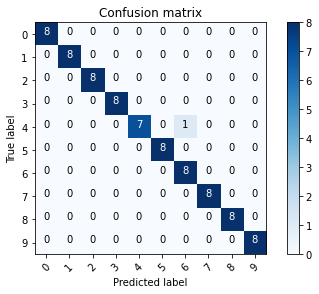

In [30]:
plot_confusion_matrix(cm, cm_plot_labels)